$$
\Large \text{MLP Model with One Hidden Layer and Multiple Nodes}
$$

In [44]:
###-----------------
### Import Libraries
###-----------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [45]:
###----------------
#Global Variables
###----------------

from calendar import EPOCH


TEST_SIZE = 0.2
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)


N_SAMPLES = 1000
NOISE = 0.2
ALPHA = 0.1
EPOCHS = 2000

# set location of input files and output files
inpDir = '../input'
outDir = '../output'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

Activation Functions

In [46]:
def sigmoid(z):
    """Returns the sigmoid of z.

    Args:
        z (float): The value to be transformed. 

    Returns:
        float: The transformed value.
    """
    return 1 / (1 + np.exp(-z))


def tanh(z):
    """Returns the tanh of z.

    Args:
        z (float): The value to be transformed. 

    Returns:
        float: The transformed value.
    """
    return np.tanh(z)

Derivative of activation function

In [47]:
def fn_act_prime_tanh(z):
    """Calculate the derivative of the activation function for the tanh activation function

    Args:
        z (np.array): input to the activation function

    Returns:
        result (np.array): derivative of the activation function
    """
    return 1 - (np.tanh(z) ** 2)


# Unit Test
fn_act_prime_tanh([
    np.array([0.0, 0.5, 1.0]),
    np.array([np.inf, -np.inf, 0]),
])

array([[1.        , 0.78644773, 0.41997434],
       [0.        , 0.        , 1.        ]])

In [48]:
def predict(model, X_p):
    """Predict the output of the model for a given input
    
    Args:
        model: multilayer perceptron model
        X_t: input data matrix
        
    Returns:
        y_pred: predicted output
    
    """   

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    m=X_p.shape[0]

    # Forward propagation
    # Layer 1
    z1 = X_p.dot(W1) + b1               #  Aggregation function
    a1 = tanh(z1)

    # Layer 2
    z2 = a1.dot(W2) + b2               #  Aggregation function
    a2 = sigmoid(z2)
    
    return (a2>0.5).astype(int)

In [49]:
def fn_calculate_loss(model, X_l, y_l):
    """Calculate loss function for backpropagation

    Args:
        model (object): model object
        X_l (array): input data matrix
        y_l (array): target data matrix 
    
    
    Returns:    
        loss (float): loss function value   
    """

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    m=X_l.shape[0]

    # Forward propagation
    # Layer 1
    z1 = X_l.dot(W1) + b1               #  Aggregation function
    a1 = tanh(z1)

    # Layer 2
    z2 = a1.dot(W2) + b2               #  Aggregation function
    a2 = sigmoid(z2)

    data_loss = -y_l*np.log(a2)
    return data_loss.sum()/m


In [50]:
def plot_decision_boundary(model, X_tr, X_ts, y_tr, y_ts):
    """Plot the decision boundary for the neural network"""
    dm = 0.05

    # Ensure inputs are NumPy arrays
    X_tr = np.array(X_tr)
    X_ts = np.array(X_ts)
    y_tr = np.array(y_tr)
    y_ts = np.array(y_ts)

    # Minimum and maximum values along each axis
    x_min, x_max = X_tr[:, 0].min(), X_tr[:, 0].max() 
    y_min, y_max = X_tr[:, 1].min(), X_tr[:, 1].max()

    # Generate a grid of points with distance 'dm' using min and max values along each axis
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, dm), 
        np.arange(y_min, y_max, dm)
    )

    XX = np.c_[
        xx.ravel(),
        yy.ravel()
    ]

    y_pred = predict(model, XX)
    Z = y_pred.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    scatter_tr = ax.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr.ravel(), cmap=CMAP, edgecolors='k') 
    scatter_ts = ax.scatter(X_ts[:, 0], X_ts[:, 1], c=y_ts.ravel(), cmap=CMAP, edgecolors='k', marker='s')
    ax.set_title('Decision Boundary')
    plt.show()


In [51]:
rng = np.random.default_rng(seed=RANDOM_STATE)

In [52]:
def build_model(nn_hdim, X_t, y_t, n_epochs=EPOCHS, alpha=ALPHA):
    """Multilayer perceptron model with multiple hidden layers

    Args:
        nn_hdim: number of neurons in the hidden layer
        X_t: input data matrix  
        y_t: target data matrix

    Returns:
        model: multilayer perceptron model
    """
    loss_hist = {}

    # Getting dimensions
    m, nn_input_dim = X_t.shape   
    nn_output_shape = y_t.shape[1]
    
    # Initialize weights 
    W1 = rng.random((nn_input_dim, nn_hdim), dtype=np.float32) / np.sqrt(nn_input_dim)
    W2 = rng.random((nn_hdim, nn_output_shape), dtype=np.float32) / np.sqrt(nn_hdim)

    # Initialize biases
    b1 = np.zeros((1, nn_hdim), dtype = np.float32)
    b2 = np.zeros((1, nn_output_shape), dtype = np.float32)
 
    print(f"W1: {W1.shape} W2: {W2.shape} b1: {b1.shape} b2: {b2.shape}")

    curr_loss = 0
    loss = []
    epoch = [] 
    
    for i in range(n_epochs):
        # Forward propagation
        # Layer 1
        z1 = X_t.dot(W1) + b1               #  Aggregation function
        a1 = tanh(z1)
 
        # Layer 2
        z2 = a1.dot(W2) + b2               #  Aggregation function
        a2 = sigmoid(z2)
        
        # Backpropagation at Layer 2
        dz2 = a2 - y_t                     #  y_t should be of shape (1,m)
        dW2 = (a1.T).dot(dz2)              
        assert (dW2.shape == W2.shape), f"Shape of dW2: {dW2.shape} W2: {W2.shape} are not equal!!!"

        db2 = np.sum(dz2, axis=0, keepdims=True)
        assert (db2.shape == b2.shape), f"Shape of db2: {db2.shape} b2: {b2.shape} are not equal!!!"

        da1 = dz2.dot(W2.T)
        assert (da1.shape == a1.shape), f"Shape of da1: {da1.shape} a1: {a1.shape} are not equal!!!"

        # Backpropagation at Layer 1
        dz1 = da1*fn_act_prime_tanh(z1)
        assert (dz1.shape == z1.shape), f"Shape of dz1: {dz1.shape} z1: {z1.shape} are not equal!!!"

        dW1 = (X_t.T).dot(dz1)
        assert (dW1.shape == W1.shape), f"Shape of dW1: {dW1.shape} W1: {W1.shape} are not equal!!!"

        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert (db1.shape == b1.shape), f"Shape of db1: {db1.shape} b1: {b1.shape} are not equal!!!"

        # Update Gradient weights
        W1 = W1 - alpha*dW1/m
        W2 = W2 - alpha*dW2/m
        b1 = b1 - alpha*db1/m
        b2 = b2 - alpha*db2/m

        model = {
            'W1': W1,
            'W2': W2,
            'b1': b1,
            'b2': b2, 
        }

        if (i+1)%100==0:
            curr_loss = fn_calculate_loss(model, X_t, y_t)
            loss.append(curr_loss)
            epoch.append(i)

            if (i+1)%1000==0:
                print(f"Epoch: {i+1} Loss: {curr_loss:>0.5f}")

    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss



    return model, loss_hist

---
$$
\textbf{Make Moon Dataset}
$$

In [53]:
X, y = datasets.make_moons(
    n_samples=N_SAMPLES,
    noise=NOISE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

X.shape, y.shape


((1000, 2), (1000,))

In [54]:
df = pd.DataFrame(X, columns=["X_1", "X_2"])
df["target"] = y
df.head()

,X_1,X_2,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


<Figure size 1500x400 with 0 Axes>

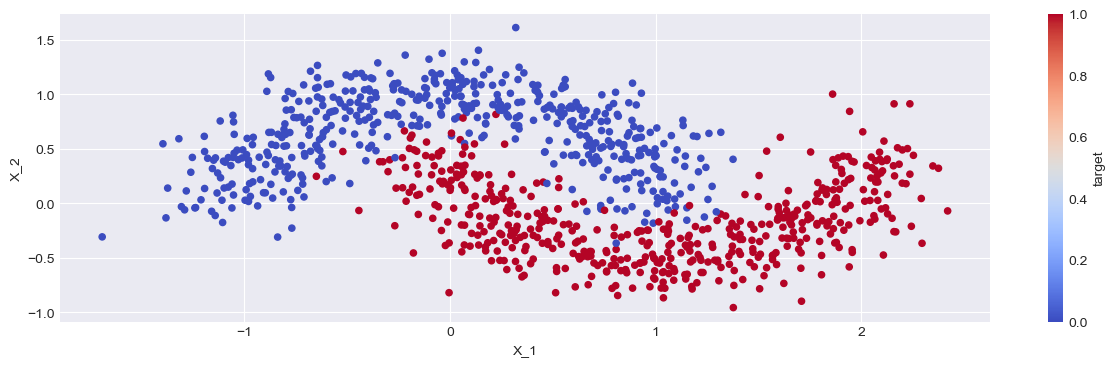

In [55]:
plt.figure()
df.plot.scatter(x="X_1", y="X_2", c="target", cmap=CMAP)
plt.show() 

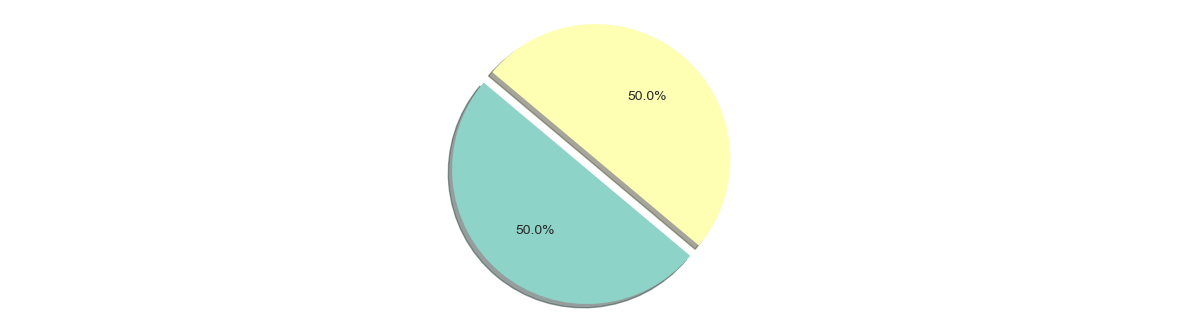

In [56]:
fix, axis = plt.subplots()
explode = (0, 0.1,) # only "explode" the 2nd ring
axis.pie(
    df['target'].value_counts(), 
    explode=explode, 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=140
)
axis.axis('equal') 
plt.show()

In [57]:
features_df = df.drop('target', axis=1)
labels_df = df['target'].to_numpy()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_df
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [59]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_train.shape, y_test.shape

((800, 1), (200, 1))

In [60]:
model, loss_hist = build_model(
    nn_hdim=4,
    X_t=X_train.to_numpy(),
    y_t=y_train,
    n_epochs=20000, 
    alpha=ALPHA
)

W1: (2, 4) W2: (4, 1) b1: (1, 4) b2: (1, 1)
Epoch: 1000 Loss: 0.14812
Epoch: 2000 Loss: 0.11364
Epoch: 3000 Loss: 0.07978
Epoch: 4000 Loss: 0.05992
Epoch: 5000 Loss: 0.04289
Epoch: 6000 Loss: 0.03557
Epoch: 7000 Loss: 0.03220
Epoch: 8000 Loss: 0.03052
Epoch: 9000 Loss: 0.02960
Epoch: 10000 Loss: 0.02906
Epoch: 11000 Loss: 0.02872
Epoch: 12000 Loss: 0.02849
Epoch: 13000 Loss: 0.02833
Epoch: 14000 Loss: 0.02822
Epoch: 15000 Loss: 0.02813
Epoch: 16000 Loss: 0.02806
Epoch: 17000 Loss: 0.02801
Epoch: 18000 Loss: 0.02795
Epoch: 19000 Loss: 0.02790
Epoch: 20000 Loss: 0.02786


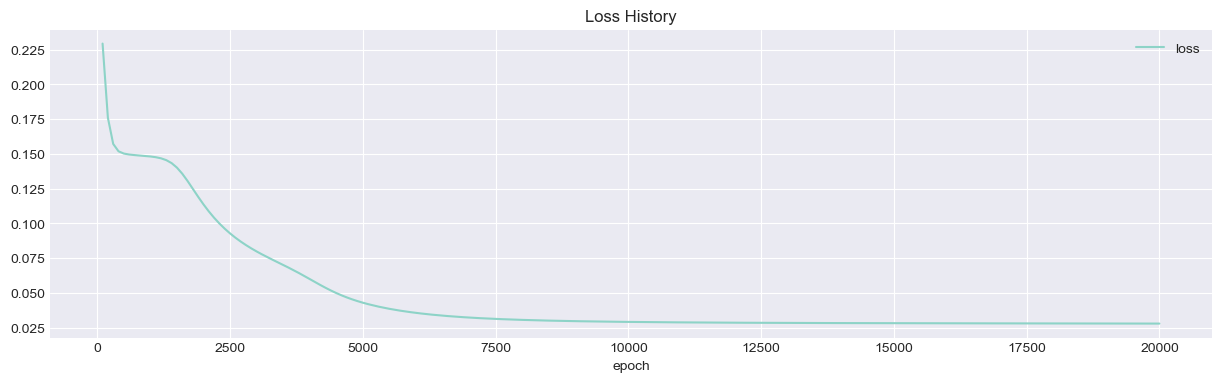

In [61]:
pd.DataFrame(loss_hist).plot(x='epoch', y='loss', title='Loss History')
plt.show()

In [62]:
def confusion_mattrix_accuracy_opt(model, X_m, y_m):
    """Returns confusion matrix and accuracy of the model

    Args:
        wts (array): weights of the model       
        X (array): input data

    Returns:
        confusion matrix and accuracy of the model
    """ 
    y_pred = predict(model, X_m)

    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_pred, y_m)
    acc = accuracy_score(y_pred, y_m) 
    
    return cm, acc

'Accuracy score is 0.98125'

,0,1
0,393,8
1,7,392


<Figure size 1000x1000 with 0 Axes>

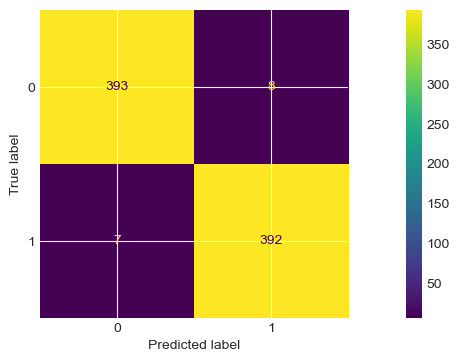

In [63]:
cm, acc = confusion_mattrix_accuracy_opt(model, X_train,y_train)
display(f'Accuracy score is {acc}')
display(pd.DataFrame(cm))    


plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)
disp.plot()
plt.show()  


'Accuracy score is 0.965'

,0,1
0,98,5
1,2,95


<Figure size 1000x1000 with 0 Axes>

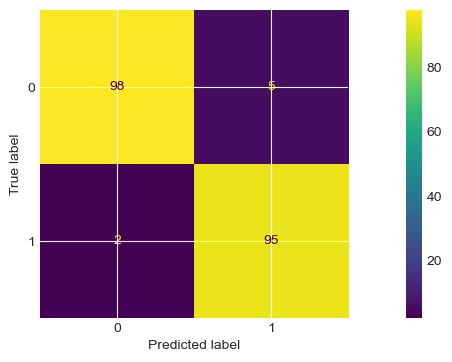

In [64]:
cm, acc = confusion_mattrix_accuracy_opt(model, X_test,y_test)
display(f'Accuracy score is {acc}')
display(pd.DataFrame(cm))    


plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)
disp.plot()
plt.show()  


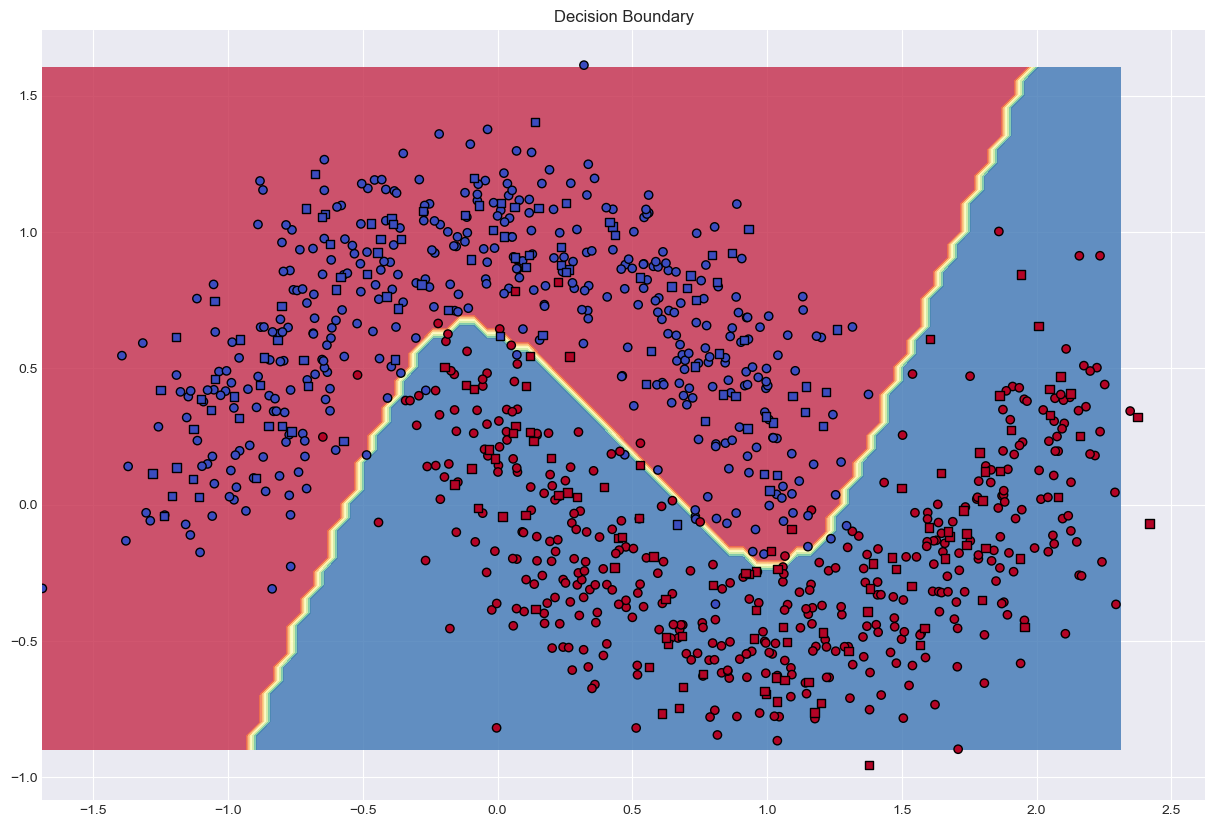

In [65]:
plot_decision_boundary(
    model, 
    X_train,
    X_test,
    y_train,
    y_test
)


In [66]:
n_dims_ar = [1,4,10,50]
alpha_ar = [1,0.1,0.01,0.001]

results = []
for n_dim in n_dims_ar:
    for alpha in alpha_ar:
        model, loss_hist = build_model(
            nn_hdim=n_dim,
            X_t=X_train.to_numpy(),
            y_t=y_train,
            n_epochs=20000, 
            alpha=alpha
        )
        _, acc_tr = confusion_mattrix_accuracy_opt(model, X_train,y_train)
        _, acc_ts = confusion_mattrix_accuracy_opt(model, X_test,y_test)
        
        results.append({
            'n_dims': n_dim,
            'alpha': alpha,
            'accuracy_train': acc_tr,
            'accuracy_test': acc_ts
        })
        


W1: (2, 1) W2: (1, 1) b1: (1, 1) b2: (1, 1)
Epoch: 1000 Loss: 0.18184
Epoch: 2000 Loss: 0.18188
Epoch: 3000 Loss: 0.18188
Epoch: 4000 Loss: 0.18188
Epoch: 5000 Loss: 0.18188
Epoch: 6000 Loss: 0.18188
Epoch: 7000 Loss: 0.18188
Epoch: 8000 Loss: 0.18188
Epoch: 9000 Loss: 0.18188
Epoch: 10000 Loss: 0.18188
Epoch: 11000 Loss: 0.18188
Epoch: 12000 Loss: 0.18188
Epoch: 13000 Loss: 0.18188
Epoch: 14000 Loss: 0.18188
Epoch: 15000 Loss: 0.18188
Epoch: 16000 Loss: 0.18188
Epoch: 17000 Loss: 0.18188
Epoch: 18000 Loss: 0.18188
Epoch: 19000 Loss: 0.18188
Epoch: 20000 Loss: 0.18188
W1: (2, 1) W2: (1, 1) b1: (1, 1) b2: (1, 1)
Epoch: 1000 Loss: 0.15196
Epoch: 2000 Loss: 0.15001
Epoch: 3000 Loss: 0.14908
Epoch: 4000 Loss: 0.14853
Epoch: 5000 Loss: 0.14816
Epoch: 6000 Loss: 0.14789
Epoch: 7000 Loss: 0.14768
Epoch: 8000 Loss: 0.14752
Epoch: 9000 Loss: 0.14739
Epoch: 10000 Loss: 0.14728
Epoch: 11000 Loss: 0.14718
Epoch: 12000 Loss: 0.14710
Epoch: 13000 Loss: 0.14703
Epoch: 14000 Loss: 0.14696
Epoch: 15000

In [67]:
pd.DataFrame(results)

,n_dims,alpha,accuracy_train,accuracy_test
0,1,1.000,0.86875,0.870
1,1,0.100,0.87250,0.855
2,1,0.010,0.87250,0.855
3,1,0.001,0.85875,0.840
4,4,1.000,0.98250,0.965
5,4,0.100,0.98250,0.965
6,4,0.010,0.89750,0.900
7,4,0.001,0.84500,0.815
8,10,1.000,0.98375,0.965
9,10,0.100,0.98250,0.965


---
$$
\textbf{Make Circle Dataset}
$$

In [68]:
X, y = datasets.make_circles(
    n_samples=N_SAMPLES,
    noise=NOISE/4, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

X.shape, y.shape


((1000, 2), (1000,))

In [69]:
df = pd.DataFrame(X, columns=["X_1", "X_2"])
df["target"] = y
df.head()

,X_1,X_2,target
0,-0.018428,1.039234,0
1,-0.386818,-0.974252,0
2,0.752975,-0.173311,1
3,0.968886,-0.338866,0
4,1.001112,-0.109452,0


<Figure size 1500x400 with 0 Axes>

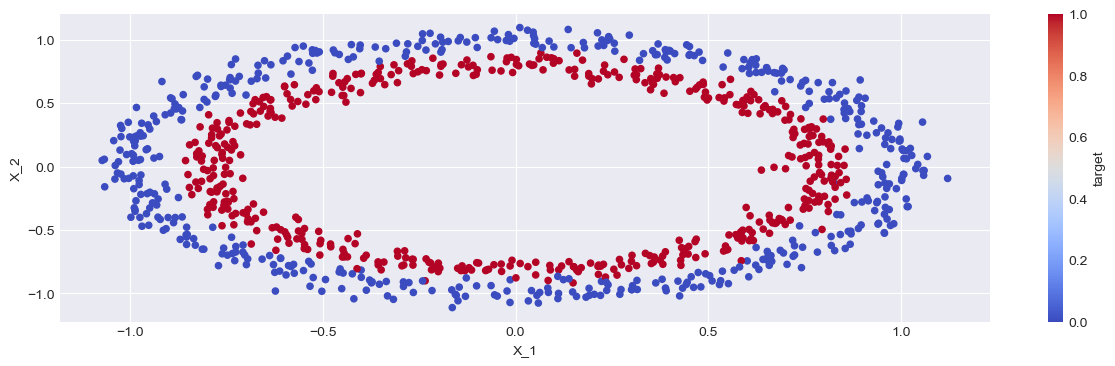

In [70]:
plt.figure()
df.plot.scatter(x="X_1", y="X_2", c="target", cmap=CMAP)
plt.show() 

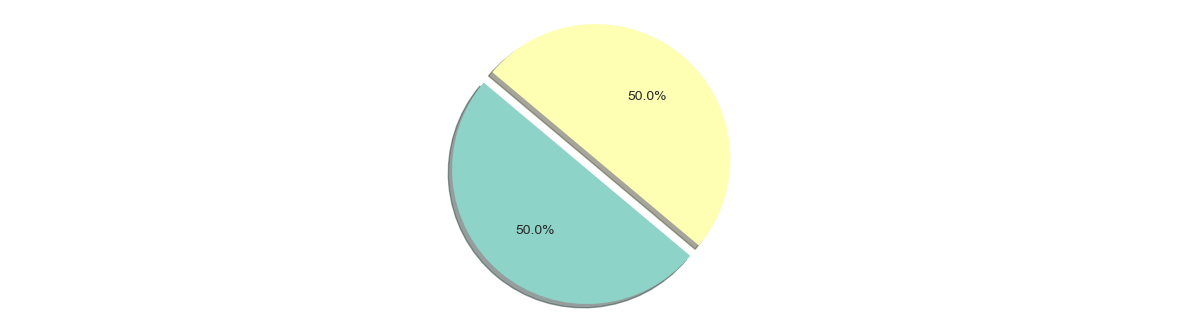

In [74]:
fix, axis = plt.subplots()
explode = (0, 0.1,) # only "explode" the 2nd ring
axis.pie(
    df['target'].value_counts(), 
    explode=explode, 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=140
)
axis.axis('equal') 
plt.show()

In [71]:
features_df = df.drop('target', axis=1)
labels_df = df['target'].to_numpy()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_df
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

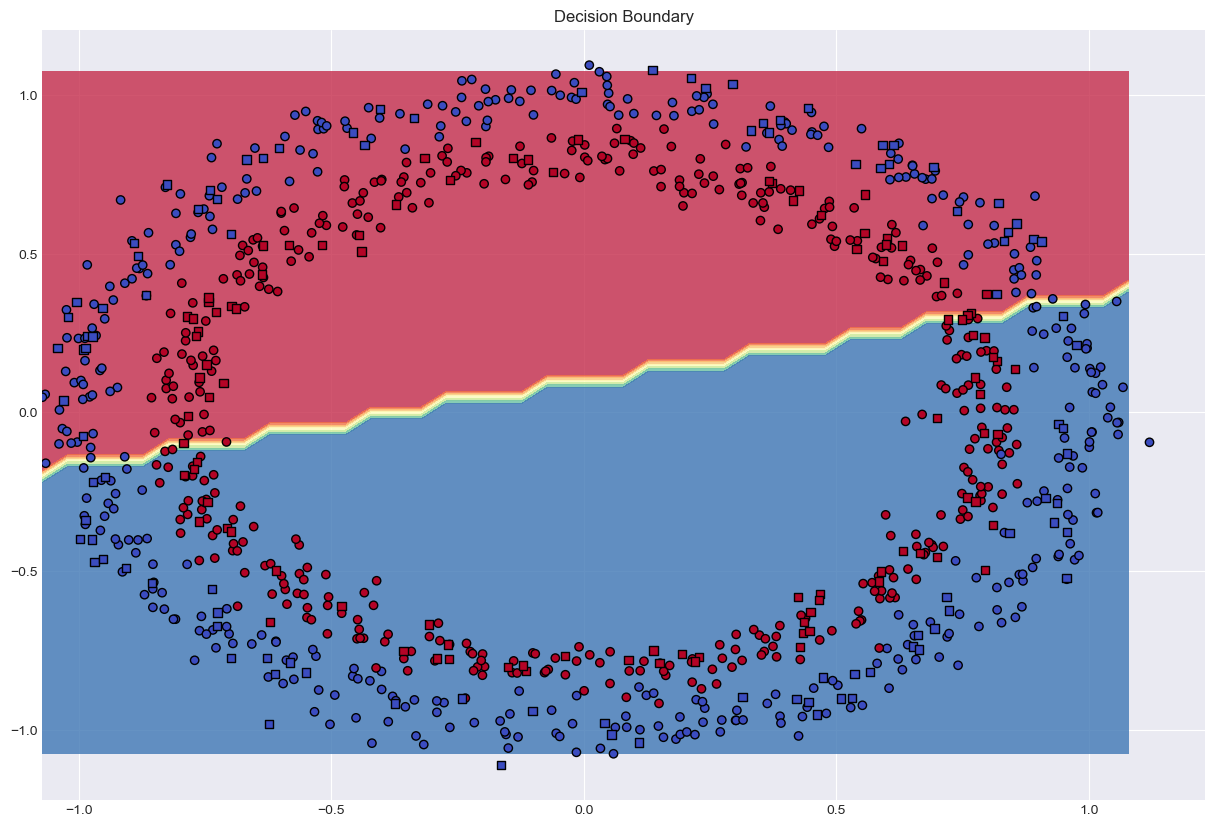

In [73]:
plot_decision_boundary(
    model, 
    X_train,
    X_test,
    y_train,
    y_test
)


https://www.youtube.com/watch?v=1aM1KYvl4Dw